## Feature Engineering for the exogenous variables

This notebook performs feature engineering on the exogenous variables present in the dataset (solar generation, wind generation, load forecasts) for use in the predictive models that will be developed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
import ..src import config
from ..src.feat_engineering_utils import fitBump, fitChebyshevPolynomials

In [2]:
# Read data (skipping the first row on 2014-12-31:23:00:00)
X = pd.read_csv(config.DATA_DIR + 'X.csv', index_col = 0, parse_dates = True).iloc[1:,:]

### Solar Generation

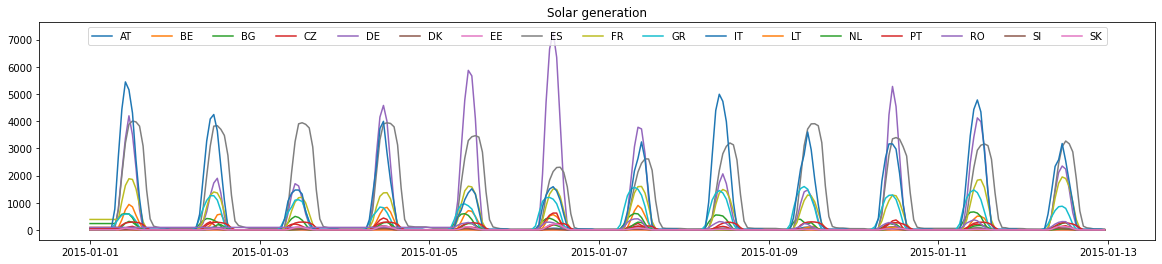

In [3]:
solarCols = [col for col in X.columns if 'solar' in col]
plt.figure(figsize = (20, 4))
plt.plot(X[solarCols].iloc[0:24*12, :])
plt.title('Solar generation');
legends = [col.split('_')[0] for col in solarCols]
plt.legend(legends, ncol = len(legends), loc = 9);

The daily solar generation for each country can be easily approximated by a single bump function:

$$f(x) = \left\{ 
  \begin{array}{ c l }
    w \times \exp\left(-\frac{1}{1 - (\sigma x) ^ 2} \right) & \quad \textrm{if } x < \frac{1}{\sigma}, \\
    0                 & \quad \textrm{otherwise}
  \end{array}
\right.$$

with $x$ being the time of day, and $w, \sigma$ the function's parameters ($\mu$ is exactly mid-day).

In [4]:
pool = Pool(4)
solarFeats = pool.map(fitBump, [X[col] for col in solarCols] )
solarFeats = pd.concat(solarFeats, axis = 1)

/kaggle/usr/lib/bump_interpolator/feat_engineering_utils.py:57: OptimizeWarning: Initial guess is not within the specified bounds
  tol    = self.tol)
/kaggle/usr/lib/bump_interpolator/feat_engineering_utils.py:57: OptimizeWarning: Initial guess is not within the specified bounds
  tol    = self.tol)
/kaggle/usr/lib/bump_interpolator/feat_engineering_utils.py:57: OptimizeWarning: Initial guess is not within the specified bounds
  tol    = self.tol)
/kaggle/usr/lib/bump_interpolator/feat_engineering_utils.py:33: RuntimeWarning: overflow encountered in exp
  f[c]  = w  * np.exp(- 1 / (1 - (s * x[c] + eps) ** 2) )
/kaggle/usr/lib/bump_interpolator/feat_engineering_utils.py:33: RuntimeWarning: overflow encountered in exp
  f[c]  = w  * np.exp(- 1 / (1 - (s * x[c] + eps) ** 2) )
/kaggle/usr/lib/bump_interpolator/feat_engineering_utils.py:33: RuntimeWarning: overflow encountered in exp
  f[c]  = w  * np.exp(- 1 / (1 - (s * x[c] + eps) ** 2) )
/kaggle/usr/lib/bump_interpolator/feat_engineerin

### Wind Generation

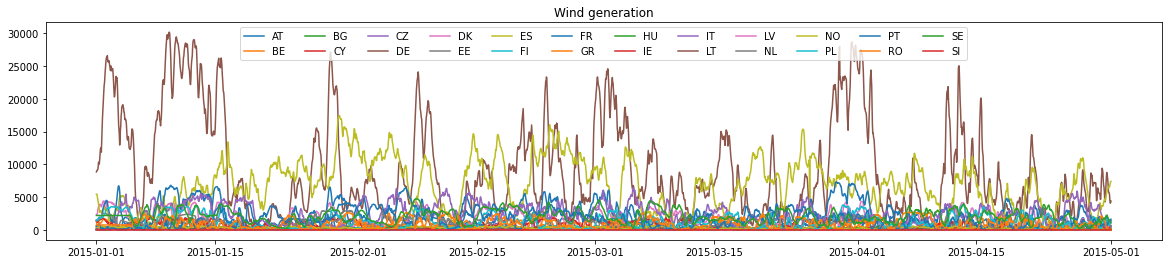

In [5]:
windCols = [col for col in X.columns if 'wind' in col]

plt.figure(figsize = (20, 4))
plt.plot(X[windCols].iloc[0:24*120, :])
plt.title('Wind generation');
legends = [col.split('_')[0] for col in windCols]
plt.legend(legends, ncol = len(legends) // 2, loc = 9);

To get an accurate represenation of daily wind generation we will use Chebyshev interpolating polynomials of 3rd order:

In [6]:
windFeats = fitChebyshevPolynomials(df    = X[windCols], 
                                    order = config.CHEBYSHEV_ORDER_WIND_FIT)

### Load forecasts

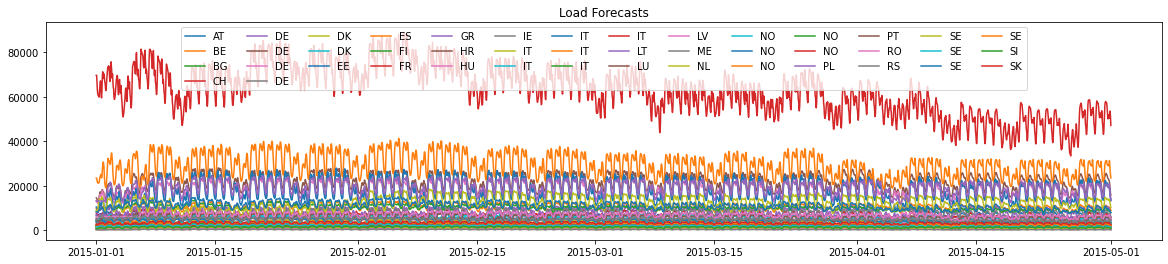

In [7]:
loadCols = [col for col in X.columns if 'load_forecast' in col]

plt.figure(figsize = (20, 4))
plt.plot(X[loadCols].iloc[0:24*120, :])
plt.title('Load Forecasts');
legends = [col.split('_')[0] for col in loadCols]
plt.legend(legends, ncol = len(legends) // 3, loc = 9);

Chebyshev polynomials will also be used for the load forecasts, but this time 6th order polynomials will be utilised.

In [8]:
loadFeats = fitChebyshevPolynomials(df    = X[loadCols], 
                                    order = config.CHEBYSHEV_ORDER_LOAD_FIT)

### Merge & save

In [9]:
X_fe = pd.concat([solarFeats, windFeats, loadFeats], axis = 1)
X_fe.to_csv('X_feature_engineering.csv')